In [25]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV

import xgboost as xgb

import mediapipe as mp
import cv2

import joblib

In [2]:
main_directory = './dataset/asl_alphabet_train/asl_alphabet_train/'

In [3]:
class_dirs = [class_dir for class_dir in os.listdir(main_directory) if os.path.isdir(os.path.join(main_directory, class_dir))]
class_dirs = sorted(class_dirs)
print(class_dirs)

FileNotFoundError: [Errno 2] No such file or directory: './dataset/asl_alphabet_train/asl_alphabet_train/'

In [ ]:
print(len(class_dirs))

24


In [ ]:
angle_range = 10
num_images_per_folder = 500

for folder_name in os.listdir(main_directory):
    folder_path = os.path.join(main_directory, folder_name)
    
    if os.path.isdir(folder_path):
        total_images = min(len(os.listdir(folder_path)), num_images_per_folder)
        current_image = 0
        
        for image_name in os.listdir(folder_path):
            if current_image >= num_images_per_folder:
                break
            
            image_path = os.path.join(folder_path, image_name)
            
            if os.path.isfile(image_path):
                image = cv2.imread(image_path)
                
                for i in range(num_images_per_folder):
                    if current_image >= num_images_per_folder:
                        break
                    
                    angle = np.random.uniform(-angle_range, angle_range)
                    M = cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), angle, 1)
                    rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
                    new_image_name = f"rotated_{i}_{image_name}"
                    new_image_path = os.path.join(folder_path, new_image_name)
                    cv2.imwrite(new_image_path, rotated_image)
                    
                    current_image += 1
                    percentage = (current_image / total_images) * 100
                    print(f"Progress: {percentage:.2f}% complete", end='\r')

print("Progress: 100.00% complete")

Progress: 100.00% complete


In [ ]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True,
                       max_num_hands=1,
                       min_detection_confidence=0.9)

E0000 00:00:1707217257.280689    4548 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1707217257.280876    4548 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1707217257.280907    4548 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)


In [ ]:
keypoints_all = []

for i, class_dir in enumerate(class_dirs):
    class_path = os.path.join(main_directory, class_dir)
    for j, image_file in enumerate(os.listdir(class_path)):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)
        if image is None:
            continue
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                keypoints = []
                for lm in hand_landmarks.landmark:
                    keypoints.append((lm.x, lm.y, lm.z))
                if keypoints:
                    keypoints_all.append({
                        'label': class_dir,
                        'keypoints': keypoints
                    })

        total_images = len(class_dirs) * len(os.listdir(class_path))
        percentage = (i * len(os.listdir(class_path)) + j) / total_images * 100
        print(f"Progress: {percentage:.2f}% complete", end='\r')

print("Progress: 100.00% complete")

Progress: 100.00% complete


In [ ]:
df = pd.DataFrame(keypoints_all)

In [ ]:
df.to_csv('./keypoints_xyz_0.9_v3.csv', index=False)

In [4]:
df = pd.read_csv('./versions/keypoints_xyz_0.9_v3.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38092 entries, 0 to 38091
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      38092 non-null  object
 1   keypoints  38092 non-null  object
dtypes: object(2)
memory usage: 595.3+ KB


In [6]:
df.describe()

,label,keypoints
count,38092,38092
unique,24,38092
top,F,"[(0.5819043517112732, 0.681418776512146, -7.76..."
freq,2190,1


In [7]:
class_counts = df['label'].value_counts()
print(class_counts)

label
F    2190
V    2156
Y    2140
K    2111
U    2051
W    2017
R    1981
I    1741
B    1729
X    1716
T    1706
L    1691
S    1672
D    1649
H    1639
G    1595
E    1505
A    1367
P    1341
Q    1304
O    1088
C     935
M     452
N     316
Name: count, dtype: int64


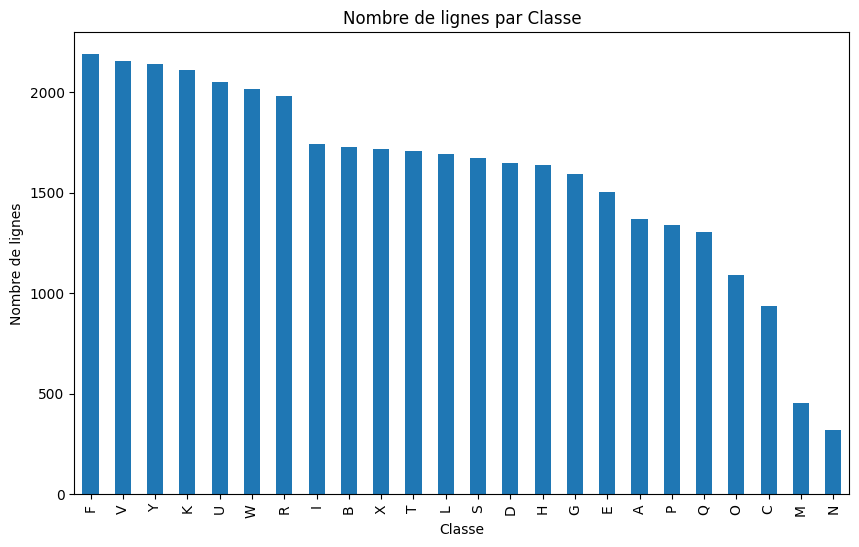

In [8]:
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Nombre de lignes')
plt.title('Nombre de lignes par Classe')
plt.show()

In [9]:
seuil_bas = 0
seuil_haut = 317

classes_to_keep = class_counts[class_counts >= seuil_bas].index
df_filtered = pd.DataFrame(columns=df.columns)
for classe in classes_to_keep:
    df_classe = df[df['label'] == classe]
    if len(df_classe) > seuil_haut:
        df_classe = df_classe.head(seuil_haut)
    df_filtered = pd.concat([df_filtered, df_classe], ignore_index=True)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7607 entries, 0 to 7606
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      7607 non-null   object
 1   keypoints  7607 non-null   object
dtypes: object(2)
memory usage: 119.0+ KB


In [10]:
df_filtered.head(5)

,label,keypoints
0,F,"[(0.7513758540153503, 0.8790234327316284, 7.11..."
1,F,"[(0.5941231846809387, 0.8328999280929565, 9.46..."
2,F,"[(0.41536805033683777, 0.9190069437026978, 5.9..."
3,F,"[(0.45164239406585693, 0.7461936473846436, 7.9..."
4,F,"[(0.6129147410392761, 0.8815302848815918, 1.22..."


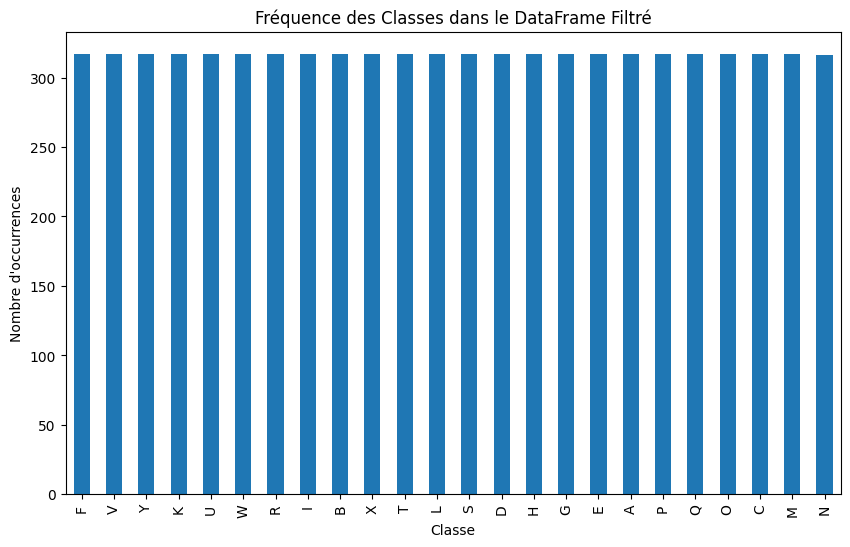

In [11]:
class_counts_filtered = df_filtered['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts_filtered.plot(kind='bar')
plt.xlabel('Classe')
plt.ylabel('Nombre d\'occurrences')
plt.title('Fréquence des Classes dans le DataFrame Filtré')
plt.show()

In [12]:
class_counts_filtered.__len__()

24

In [13]:
def transform_tuples(row):
    keypoints = eval(row)
    return [coord for point in keypoints for coord in point]
# df_filtered['keypoints'] = df_filtered['keypoints'].apply(transform_tuples)
# print(df_filtered.head())
df['keypoints'] = df['keypoints'].apply(transform_tuples)
# print(df.head())

In [14]:
df.head()

,label,keypoints
0,A,"[0.35990989208221436, 0.8417818546295166, -6.4..."
1,A,"[0.6427100896835327, 0.5379325151443481, -4.73..."
2,A,"[0.7046040892601013, 0.8876957893371582, -3.95..."
3,A,"[0.6484864950180054, 0.902927041053772, -6.277..."
4,A,"[0.6400114893913269, 0.5368986129760742, -5.12..."


In [15]:
# X = pd.DataFrame(df_filtered['keypoints'].tolist())
X = pd.DataFrame(df['keypoints'].tolist())
# y = df_filtered['label']
y = df['label']

In [16]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,0.359910,0.841782,-6.401782e-07,0.488364,0.792041,-0.052786,0.602923,0.661631,-0.065377,0.637256,...,-0.027966,0.275711,0.535906,-0.090413,0.279718,0.634426,-0.077845,0.292941,0.705483,-0.047358
1,0.642710,0.537933,-4.737965e-07,0.717116,0.490953,-0.024451,0.767030,0.404392,-0.033038,0.780463,...,-0.027342,0.580487,0.334240,-0.057323,0.595486,0.386191,-0.046561,0.602817,0.434143,-0.028137
2,0.704604,0.887696,-3.950246e-07,0.787732,0.856636,-0.027290,0.851443,0.769214,-0.033207,0.859110,...,-0.025883,0.652953,0.692496,-0.067224,0.663558,0.752203,-0.061764,0.667211,0.802050,-0.045413
3,0.648486,0.902927,-6.277843e-07,0.767491,0.850801,-0.051007,0.867934,0.707386,-0.062452,0.888591,...,-0.037729,0.551561,0.612532,-0.102903,0.570626,0.712340,-0.092025,0.587531,0.780870,-0.062175
4,0.640011,0.536899,-5.125659e-07,0.713374,0.488918,-0.024532,0.759897,0.401448,-0.033597,0.770247,...,-0.027712,0.571359,0.342266,-0.057495,0.586448,0.394417,-0.047843,0.596394,0.442746,-0.030497


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
models = [
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    SVC(),
    KNeighborsClassifier()
]

for model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5) 
    print(f"Model: {type(model).__name__}")
    print(f"Cross-validation scores: {scores}")
    print(f"Mean score: {scores.mean()}")
    print(f"Standard deviation: {scores.std()}")

/home/mathieu/projects/asl_web_app/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/mathieu/projects/asl_web_app/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

Model: LogisticRegression
Cross-validation scores: [0.97358491 0.97063167 0.97407711 0.972596   0.97095504]
Mean score: 0.9723689434301495
Standard deviation: 0.001375879560646934
Model: DecisionTreeClassifier
Cross-validation scores: [0.91616079 0.91419196 0.91255127 0.9133574  0.9172957 ]
Mean score: 0.9147114242198986
Standard deviation: 0.0017634409864640873
Model: RandomForestClassifier
Cross-validation scores: [0.98014766 0.98474159 0.98113208 0.98178536 0.9804726 ]
Mean score: 0.9816558575212027
Standard deviation: 0.0016424149731317523
Model: SVC
Cross-validation scores: [0.97276456 0.97588187 0.97456932 0.97571382 0.97177552]
Mean score: 0.9741410168772362
Standard deviation: 0.0016234490540052206
Model: KNeighborsClassifier
Cross-validation scores: [0.97210829 0.97604594 0.97145201 0.97046275 0.96668855]
Mean score: 0.9713515061951223
Standard deviation: 0.003005115700851795


In [19]:
model_xgb = xgb.XGBClassifier()
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

scores = cross_val_score(model_xgb, X_train, y_train_encoded, cv=5)

print(f"Model: {type(model_xgb).__name__}")
print(f"Cross-validation scores: {scores}")
print(f"Mean score: {scores.mean()}")
print(f"Standard deviation: {scores.std()}")

Model: XGBClassifier
Cross-validation scores: [0.98736669 0.98835111 0.98949959 0.98916968 0.98949787]
Mean score: 0.9887769866297571
Standard deviation: 0.0008205274028977233


In [21]:
model_xgb = xgb.XGBClassifier()
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

param_grid = {
    'max_depth': 7,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

model_xgb.set_params(**param_grid)
model_xgb.fit(X_train, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [22]:
y_pred = model_xgb.predict(X_test)
report = classification_report(y_test_encoded, y_pred)
cm = confusion_matrix(y_test_encoded, y_pred)
print("Rapport de classification :")
print(report)

Rapport de classification :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       287
           1       0.99      1.00      1.00       347
           2       1.00      0.99      1.00       184
           3       1.00      0.99      0.99       323
           4       1.00      0.99      1.00       309
           5       1.00      1.00      1.00       448
           6       0.99      0.99      0.99       293
           7       0.99      0.99      0.99       306
           8       1.00      1.00      1.00       335
           9       1.00      1.00      1.00       430
          10       1.00      1.00      1.00       294
          11       0.97      0.93      0.95       105
          12       0.92      0.95      0.94        63
          13       0.99      1.00      0.99       209
          14       1.00      0.99      0.99       264
          15       1.00      0.99      0.99       269
          16       0.99      0.98      0.98       382

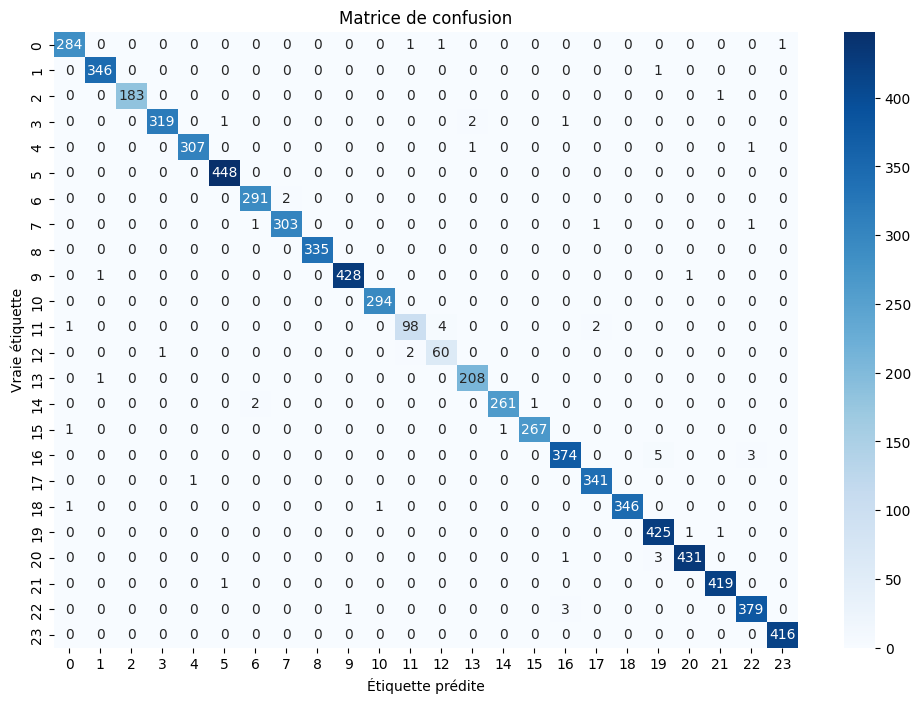

In [23]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.ylabel('Vraie étiquette')
plt.xlabel('Étiquette prédite')
plt.title('Matrice de confusion')
plt.show()

In [30]:
# Define the number of training examples to use for the learning curve
train_sizes = np.linspace(0.1, 1.0)

# Calculate the learning curve scores
train_sizes, train_scores, test_scores = learning_curve(model_xgb, X_train, y_train_encoded, train_sizes=train_sizes, cv=5)

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_scores_mean, label='Cross-validation score', color='red')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='red')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [ ]:
joblib.dump(model_xgb, 'model_xgb_xyz_0.9_v2.pkl')

['model_xgb_xyz_0.9_v2.pkl']

In [ ]:
model = joblib.load('model_xgb_xyz_0.9_v1.pkl')

In [ ]:
class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

cap = cv2.VideoCapture(0)
mp_hands = mp.solutions.hands.Hands(static_image_mode=False,
                                    max_num_hands=1,
                                    min_detection_confidence=0.5,
                                    min_tracking_confidence=0.5)

while True:
    ret, frame = cap.read()

    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    results = mp_hands.process(frame_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            keypoints = [(lm.x, lm.y) for lm in hand_landmarks.landmark]
            keypoints = np.array(keypoints).flatten()
            prediction = model.predict([keypoints])
            prediction = class_names[prediction[0]]
            cv2.putText(frame, prediction, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    cv2.imshow('Handpose', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[ WARN:0@304.548] global cap_v4l.cpp:997 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@304.549] global obsensor_uvc_stream_channel.cpp:159 getStreamChannelGroup Camera index out of range
E0000 00:00:1707216544.080047    4548 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1707216544.080096    4548 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)
E0000 00:00:1707216544.080116    4548 gl_context.cc:408] INTERNAL: ; RET_CHECK failure (mediapipe/gpu/gl_context_egl.cc:303) successeglMakeCurrent() returned error 0x3008;  (entering GL context)


In [ ]:
# param_grid = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
#     'n_estimators': [100, 200, 300],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }

# grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, cv=5, n_jobs=4)
# grid_search.fit(X_train, y_train_encoded)

# print("Meilleurs hyperparamètres :")
# print(grid_search.best_params_)

Meilleurs hyperparamètres :
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


In [ ]:
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

In [ ]:
# scores = cross_val_score(best_model, X_train, y_train_encoded, cv=5)

# print(f"Model: {type(best_model).__name__}")
# print(f"Cross-validation scores: {scores}")
# print(f"Mean score: {scores.mean()}")
# print(f"Standard deviation: {scores.std()}")

Model: XGBClassifier
Cross-validation scores: [0.98619846 0.9881202  0.9881202  0.98724668 0.9886443 ]
Mean score: 0.9876659678546471
Standard deviation: 0.0008601351240455282


In [ ]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)